In [1]:
from IPython.display import clear_output
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d sumanthvrao/daily-climate-time-series-data
!unzip daily-climate-time-series-data.zip
!rm daily-climate-time-series-data.zip
!pip install -q pmdarima
clear_output()

In [43]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier

from pmdarima.arima import auto_arima
from scipy import stats

import tensorflow as tf
from itertools import combinations

In [3]:
np.random.seed(123)

def regression_results(y_true, y_pred):
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [4]:
train = pd.read_csv('DailyDelhiClimateTrain.csv')
test = pd.read_csv('DailyDelhiClimateTest.csv')
train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [23]:
train.info()  # no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


In [25]:
train.describe()  # normal distribution

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


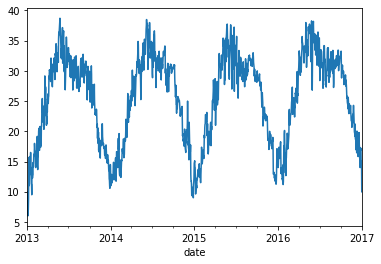

In [5]:
ds = pd.Series(data=train['meantemp'].values, index=pd.to_datetime(train.date))
ds.plot()  # yearly seasonality?, no significant outliers or anomalies

In [6]:
def correlation(df: pd.DataFrame, alpha=0.05, threshold=0.66, method='pearson'):
    data = df.copy()
    columns = data.select_dtypes(exclude=['category', np.object]).columns
    for pair in combinations(columns, r=2):
        col1, col2 = pair
        if method == 'pearson':
            r, pvalue = stats.pearsonr(data[col1], data[col2])
        elif method == 'kendall':
            r, pvalue = stats.kendalltau(data[col1], data[col2])
        elif method == 'spearman':
            r, pvalue = stats.spearmanr(data[col1], data[col2])                   
        else:
            raise ValueError(f'Method should be "spearman", "kendall" or "pearson", got: {method}')
        if r >= threshold:    
            if pvalue < alpha:
                print(f'Correlation ({method}) between {col1} and {col2} is statisticaly strong: {r:.4f}.')
            else:
                print(f'Correlation ({method}) between {col1} and {col2} is high but not statisticaly meaningful.')

In [74]:
correlation(train.drop('date', axis=1), threshold=0.3, method='spearman')  # no actually strong correlations

Correlation (spearman) between meantemp and wind_speed is statisticaly strong: 0.3727.
Correlation (spearman) between humidity and meanpressure is statisticaly strong: 0.3097.


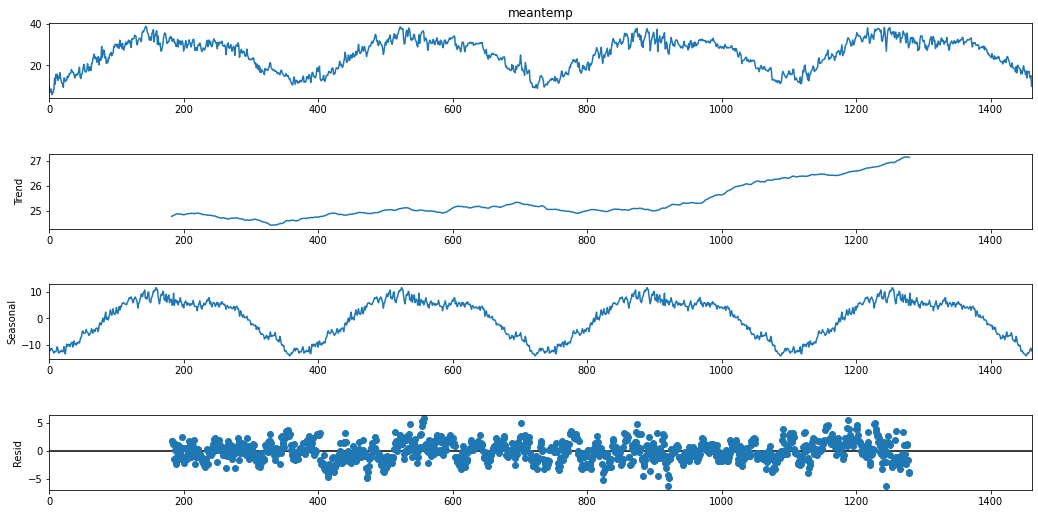

In [7]:
decompose = seasonal_decompose(train['meantemp'], model='additive', period=365)
fig = decompose.plot()
fig.set_figheight(8)
fig.set_figwidth(16)
plt.show()

In [45]:
dftest = adfuller(train['meantemp'].diff().dropna(), autolag='AIC', regression='ct')
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'], dftest))
# the data is stationary, d=1

{'adf': -16.466643282135145,
 'criticalvalues': {'1%': -3.9650227606650352,
  '10%': -3.1288338150660353,
  '5%': -3.4135200819990335},
 'icbest': 5422.485697443508,
 'nobs': 1451,
 'pvalue': 0.0,
 'usedlag': 9}

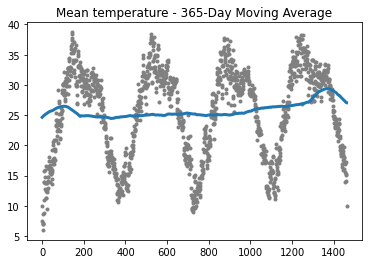

In [49]:
moving_average = train['meantemp'].rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = train['meantemp'].plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Mean temperature - 365-Day Moving Average", legend=False,
);
# trend

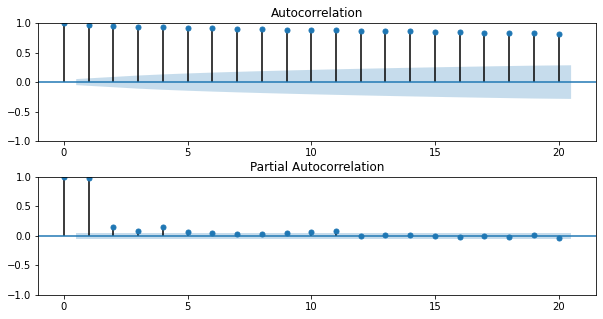

In [52]:
# one diff
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
fig = plot_acf(train['meantemp'], lags=20, ax=ax[0])
fig = plot_pacf(train['meantemp'], lags=20, ax=ax[1])
plt.subplots_adjust(hspace=0.3)
plt.show()

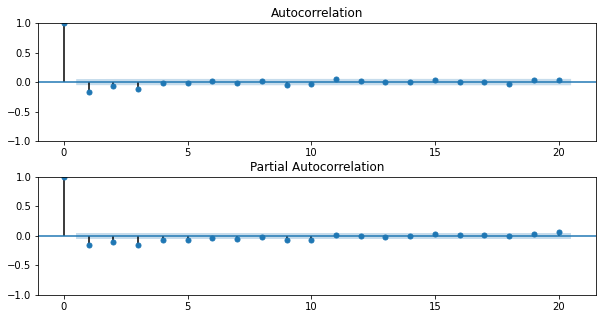

In [53]:
# one diff
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
fig = plot_acf(train['meantemp'].diff().dropna(), lags=20, ax=ax[0])
fig = plot_pacf(train['meantemp'].diff().dropna(), lags=20, ax=ax[1])
plt.subplots_adjust(hspace=0.3)
plt.show()
# p = 1, q = 0, q = 1..5, use 2-4 lag-features

In [8]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [ ]:
train['date'] = pd.to_datetime(train['date'])
train_ = train.set_index('date').to_period('D')

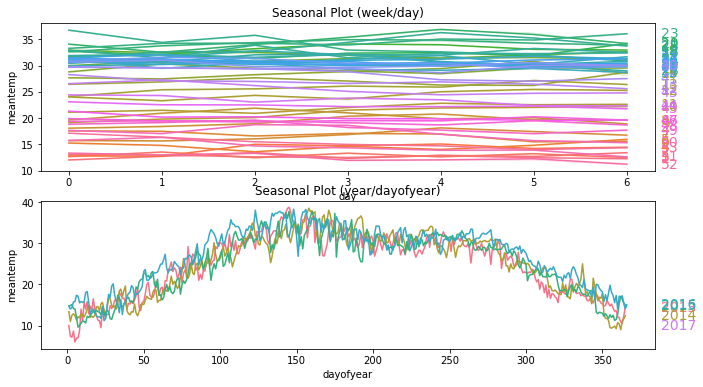

In [10]:
X = train_.copy()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="meantemp", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="meantemp", period="year", freq="dayofyear", ax=ax1);

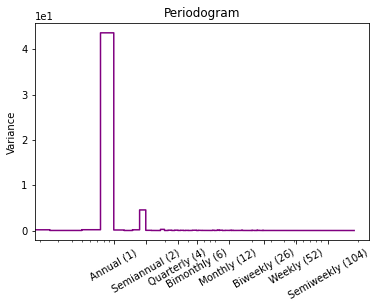

In [64]:
plot_periodogram(train['meantemp'])  # ANNUAL seasonality

In [11]:
fourier = CalendarFourier(freq="A", order=2)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=train_.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample() 

In [68]:
X.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)"
date,,,,,,,,,,,,
2013-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000
2013-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.017213,0.999852,0.034422,0.999407
2013-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.034422,0.999407,0.068802,0.997630
2013-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.051620,0.998667,0.103102,0.994671
2013-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.068802,0.997630,0.137279,0.990532


In [70]:
train.corr()

,meantemp,humidity,wind_speed,meanpressure
meantemp,1.000000,-0.571951,0.306468,-0.038818
humidity,-0.571951,1.000000,-0.373972,0.001734
wind_speed,0.306468,-0.373972,1.000000,-0.020670
meanpressure,-0.038818,0.001734,-0.020670,1.000000


In [82]:
roll_train_exp = train['meantemp'].ewm(span=10, adjust=False).mean()
weights = np.arange(1,11)
roll_train_w = train['meantemp'].rolling(10).apply(lambda x: np.dot(x, weights)/weights.sum(), raw=True)
roll_train_ = train['meantemp'].rolling(window=10).mean()

In [78]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)

In [79]:
make_lags(ds, 4)

,y_lag_1,y_lag_2,y_lag_3,y_lag_4
date,,,,
2013-01-01,NaN,NaN,NaN,NaN
2013-01-02,10.000000,NaN,NaN,NaN
2013-01-03,7.400000,10.000000,NaN,NaN
2013-01-04,7.166667,7.400000,10.000000,NaN
2013-01-05,8.666667,7.166667,7.400000,10.000000
...,...,...,...,...
2016-12-28,16.850000,17.142857,14.000000,17.318182
2016-12-29,17.217391,16.850000,17.142857,14.000000
2016-12-30,15.238095,17.217391,16.850000,17.142857


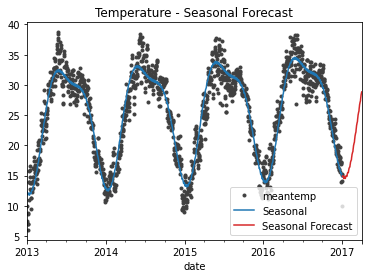

In [84]:
y = train_["meantemp"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=train_.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Temperature - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

In [31]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            return X
        return X[self.columns]

class Fourier(BaseEstimator, TransformerMixin):
    def __init__(self, season="A", order=2):
        self.fourier = CalendarFourier(freq=season, order=order)
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_ = X.copy()
        dp = DeterministicProcess(
            index=X_.index,
            constant=True,               # dummy feature for bias (y-intercept)
            order=1,                     # trend (order 1 means linear)
            seasonal=True,               # weekly seasonality (indicators)
            additional_terms=[self.fourier],  # annual seasonality (fourier)
            drop=True,                   # drop terms to avoid collinearity
        )
        X_ = dp.in_sample() 
        return X_

class RollingWindow(BaseEstimator, TransformerMixin):
    def __init__(self, window_size=5, method=None):
        self.method = method
        self.window_size = window_size

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        roll_exp = X['meantemp'].ewm(span=self.window_size, adjust=False).mean()
        weights = np.arange(1,self.window_size+1)
        roll_w = X['meantemp'].rolling(self.window_size).apply(lambda x: np.dot(x, weights)/weights.sum(), raw=True)
        roll_ = X['meantemp'].rolling(window=self.window_size).mean()
        return pd.concat([roll_exp, roll_w, roll_], axis=1)

class LagFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, n_lags=5):
        self.n_lags = n_lags

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return self.make_lags(X, self.n_lags)

    @staticmethod
    def make_lags(ts, lags):
        return pd.concat(
            {
                f'y_lag_{i}': ts.shift(i)
                for i in range(1, lags + 1)
            },
            axis=1)

In [32]:
base_columns = ['humidity', 'wind_speed', 'meanpressure']
target_column = ['meantemp',]

base_pipe = Pipeline(steps=[('selector1', ColumnSelector(base_columns)),
                            ('scaler', MinMaxScaler())])

fourier_pipe = Pipeline(steps=[('selector2', ColumnSelector(target_column)),
                               ('fourier', Fourier())])

rolling_pipe = Pipeline(steps=[('selector3', ColumnSelector(target_column)),
                               ('rolling', RollingWindow())])

lag_pipe = Pipeline(steps=[('selector4', ColumnSelector(target_column)),
                           ('lags', LagFeatures())])

union = FeatureUnion(transformer_list=[('base', base_pipe),
                                       ('fourier_pipe', fourier_pipe),
                                       ('rolling_pipe', rolling_pipe),
                                       ('lag_pipe', lag_pipe)])

In [37]:
X_train = union.fit_transform(train_)
X_train = pd.DataFrame(data=X_train, columns=[f'ft_{i+1}' for i in range(X_train.shape[1])], index=train_.index)

In [44]:
X_train.dropna(inplace=True)
cols_to_normalize = X_train.columns[-8:].tolist()
column_normilizer = ColumnTransformer(transformers=[('norm', MinMaxScaler(), cols_to_normalize)], 
                                      remainder='passthrough')
X_train = column_normilizer.fit_transform(X_train)

In [46]:
X_train = pd.DataFrame(data=X_train, columns=[f'ft_{i+1}' for i in range(X_train.shape[1])], index=train_.index[5:])

In [57]:
X_train = X_train.iloc[:-1, :]
X_train.head()

,ft_1,ft_2,ft_3,ft_4,ft_5,ft_6,ft_7,ft_8,ft_9,ft_10,ft_11,ft_12,ft_13,ft_14,ft_15,ft_16,ft_17,ft_18,ft_19,ft_20,ft_21,ft_22,ft_23
date,,,,,,,,,,,,,,,,,,,,,,,
2013-01-06,0.005088,0.002650,0.002608,0.000000,0.081514,0.035662,0.042795,0.122271,0.801320,0.035054,0.132907,1.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,0.085965,0.996298,0.171293,0.985220
2013-01-07,0.000000,0.000000,0.000000,0.030568,0.000000,0.081514,0.035662,0.042795,0.752805,0.149218,0.133167,1.0,7.0,0.0,0.0,0.0,0.0,0.0,1.0,0.103102,0.994671,0.205104,0.978740
2013-01-08,0.017036,0.018162,0.011023,0.030568,0.030568,0.000000,0.081514,0.035662,0.580858,0.169182,0.133000,1.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.120208,0.992749,0.238673,0.971100
2013-01-09,0.084965,0.087944,0.045800,0.087336,0.030568,0.030568,0.000000,0.081514,0.436881,0.296068,0.132777,1.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.137279,0.990532,0.271958,0.962309
2013-01-10,0.097251,0.114036,0.078403,0.244541,0.087336,0.030568,0.030568,0.000000,0.561056,0.175272,0.132603,1.0,10.0,0.0,1.0,0.0,0.0,0.0,0.0,0.154309,0.988023,0.304921,0.952378


In [51]:
# X_test + 5 last rows from X_train
test['date'] = pd.to_datetime(test['date'])
test_ = test.set_index('date').to_period('D')

In [ ]:
train_ = train_.iloc[:-1, :]
to_concat = train_.iloc[-5:, :]

In [63]:
test_ = pd.concat([to_concat, test_], axis=0)

In [64]:
X_test = union.transform(test_)
X_test = pd.DataFrame(data=X_test, columns=[f'ft_{i+1}' for i in range(X_test.shape[1])], index=test_.index)

X_test.dropna(inplace=True)
cols_to_normalize = X_test.columns[-8:].tolist()
X_test = column_normilizer.transform(X_test)

X_test = pd.DataFrame(data=X_test, columns=[f'ft_{i+1}' for i in range(X_test.shape[1])], index=test_.index[5:])

In [50]:
correlation(X_train)

Correlation (pearson) between ft_1 and ft_2 is statisticaly strong: 0.9993.
Correlation (pearson) between ft_1 and ft_3 is statisticaly strong: 0.9981.
Correlation (pearson) between ft_1 and ft_4 is statisticaly strong: 0.9891.
Correlation (pearson) between ft_1 and ft_5 is statisticaly strong: 0.9847.
Correlation (pearson) between ft_1 and ft_6 is statisticaly strong: 0.9770.
Correlation (pearson) between ft_1 and ft_7 is statisticaly strong: 0.9695.
Correlation (pearson) between ft_1 and ft_8 is statisticaly strong: 0.9623.
Correlation (pearson) between ft_2 and ft_3 is statisticaly strong: 0.9980.
Correlation (pearson) between ft_2 and ft_4 is statisticaly strong: 0.9911.
Correlation (pearson) between ft_2 and ft_5 is statisticaly strong: 0.9867.
Correlation (pearson) between ft_2 and ft_6 is statisticaly strong: 0.9767.
Correlation (pearson) between ft_2 and ft_7 is statisticaly strong: 0.9652.
Correlation (pearson) between ft_2 and ft_8 is statisticaly strong: 0.9541.
Correlation 

In [87]:
lr = LinearRegression(fit_intercept=False)

lr.fit(X_train, train_['meantemp'].iloc[5:])

pred = lr.predict(X_test)

In [88]:
regression_results(test_['meantemp'].iloc[5:], pred)  # hmmm...?

explained_variance:  1.0
r2:  1.0
MAE:  0.0
MSE:  0.0
RMSE:  0.0


In [89]:
np.linalg.matrix_rank(X_train.values)

22

In [95]:
predictions = pd.Series(data=pred, index=test_.index[5:])

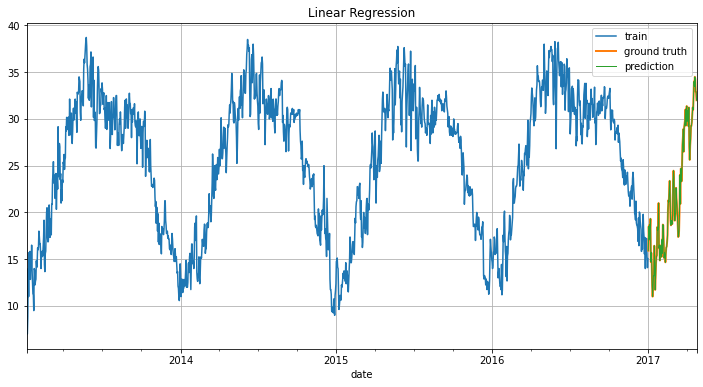

In [115]:
plt.figure(figsize=(12,6))
plt.title('Linear Regression')
train_['meantemp'].iloc[5:].plot(label='train')
test_['meantemp'].iloc[5:].plot(label='ground truth', lw=2)
predictions.plot(label='prediction', lw=1)
plt.grid()
plt.legend()
plt.show()

In [118]:
model = MultiOutputRegressor(XGBRegressor())
model.fit(X_train, train_['meantemp'].iloc[5:].values.reshape(-1,1))

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=['meantemp',])
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=['meantemp',])

[10:38:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [120]:
regression_results(test_['meantemp'].iloc[5:], y_pred)

explained_variance:  0.9608
r2:  0.9608
MAE:  1.0126
MSE:  1.5719
RMSE:  1.2538


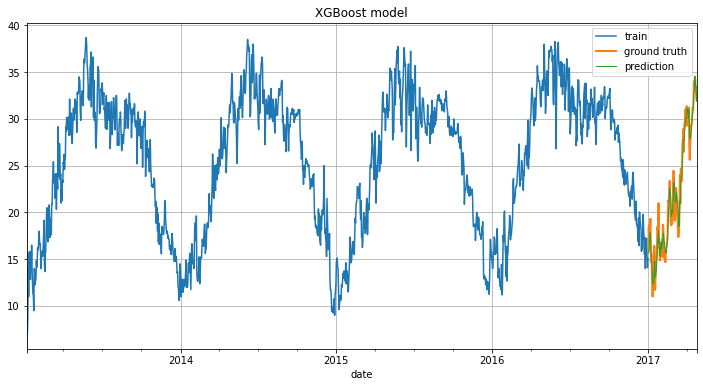

In [123]:
plt.figure(figsize=(12,6))
plt.title('XGBoost model')
train_['meantemp'].iloc[5:].plot(label='train')
test_['meantemp'].iloc[5:].plot(label='ground truth', lw=2)
y_pred['meantemp'].plot(label='prediction', lw=1)
plt.grid(True)
plt.legend()
plt.show()

In [129]:
# SARIMAX raw features
Xs_train = base_pipe.transform(train_.iloc[5:, :])
ys_train = train_['meantemp'].iloc[5:].copy()
step_wise = auto_arima(ys_train, exogenous=Xs_train, 
                       start_p=1, start_q=1,  
                       max_p=7, max_q=7,  d=1, max_d=3, 
                       trend='ct', trace=True, 
                       error_action='ignore', suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4791.309, Time=1.89 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4785.844, Time=0.94 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4787.386, Time=1.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4787.639, Time=2.88 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4785.844, Time=0.96 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 7.817 seconds


In [130]:
step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1456
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2386.922
Date:                Thu, 03 Mar 2022   AIC                           4785.844
Time:                        10:50:10   BIC                           4817.540
Sample:                             0   HQIC                          4797.670
                               - 1456                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0527      0.068      0.779      0.436      -0.080       0.185
drift       -6.41e-05   8.34e-05     -0.769      0.442      -0.000    9.94e-05
x1           -11.8250      0.252    -46.911      0.000     -12.319     -11.331
x2            -1.2514      0.271     -4.621      0.000      -1.782      -0.721
x3            -0.4001      4.828     -0.083      0.934      -9.862       9.062
sigma2         1.5576      0.037     42.185      0.000       1.485       1.630
===================================================================================
Ljung-Box (L1) (Q):                   0.46   Jarque-Bera (JB):               613.55
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                            -0.35
Prob(H) (two-sided):                  0.14   Kurtosis:                         6.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [152]:
sarima = SARIMAX(ys_train, exog=Xs_train, order=(0,1,0), seasonal_order=(0, 1, 0, 12), enforce_invertibility=False,
               enforce_stationarity=False)

In [153]:
results = sarima.fit()

In [137]:
Xs_test = test_.drop('meantemp', axis=1).iloc[5:, :]
Xs_test = base_pipe.transform(Xs_test)

In [139]:
ys_test = test_['meantemp'].iloc[5:]

In [154]:
predictions = results.predict(start=Xs_train.shape[0], end=Xs_train.shape[0] + Xs_test.shape[0] - 1, exog=Xs_test)

In [155]:
regression_results(ys_test, predictions)

explained_variance:  0.7857
r2:  0.3603
MAE:  4.2676
MSE:  25.648
RMSE:  5.0644


In [160]:
# SARIMAX with features
sarima = SARIMAX(ys_train, exog=X_train, order=(0,1,0), seasonal_order=(0, 1, 0, 12), enforce_invertibility=False,
               enforce_stationarity=False)
results = sarima.fit()

In [161]:
predictions = results.predict(start=X_train.shape[0], end=X_train.shape[0] + X_test.shape[0] - 1, exog=X_test)

In [162]:
regression_results(ys_test, predictions)

explained_variance:  1.0
r2:  1.0
MAE:  0.0
MSE:  0.0
RMSE:  0.0
